In [7]:
import pandas as pd
import gc
import time
from contextlib import contextmanager
import custom_kernel_RefOC as ckk
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, make_scorer, recall_score, roc_curve, auc
from imblearn.pipeline import Pipeline
# Estimator
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import utilitaires_810 as u810

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(name, time.time() - t0))

GIT_FOLDER = './'
DOSSIER_IMG = GIT_FOLDER+'temp_img/'
INPUT_FOLDER = GIT_FOLDER + 'processed_data/'
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [8]:
# ---------------------------------------------------------------- MAKE SCRORER
def custom_metric(y_true, y_pred) :
    faux_negs = np.sum((y_true == 1) & (y_pred == 0))
    faux_pos = np.sum((y_true == 0) & (y_pred == 1))
    true_pos = np.sum((y_true == 1) & (y_pred == 1))
    # true_negs = np.sum((y_true == 0) & (y_pred == 0))
    f2_score = true_pos/(true_pos + 0.2 * faux_pos + 0.8 * faux_negs)
    return f2_score

custom_score = make_scorer(custom_metric, greater_is_better=True)

In [9]:
train_df = pd.read_csv('./input_data/application_train.csv')
# Nettoyage des valeurs aberrantes
train_df = train_df[train_df['CODE_GENDER'] != 'XNA']  # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
train_df = ckk.full_feature_engineering(train_df, './input_data/')
X = train_df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = train_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

X_train : (246005, 632) // X_test : (61502, 632)
y_train : (246005,) // y_test : (61502,)


# TEST LOGISTIC REGRESSION OLD HPARAMS

In [4]:
# # Create an instance of the custom transformer
# feature_engineering_transformer = ckk.ApplicationProcessTransformer(path="./input_data/")
# Other transformers for pipeline
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1, random_state=RANDOM_STATE)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
estimator = LogisticRegression(class_weight='balanced', max_iter=200, penalty='l2', solver='lbfgs')

In [5]:
model = Pipeline([
    ("imputer", imputer),
    ("scaler", scaler),
    ("over", over),
    ("under", under),
    ("estimator", estimator)
])

model.fit(X_train, y_train)

/home/maximorose/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

 TRAIN F2 score model :  0.43927187618184543


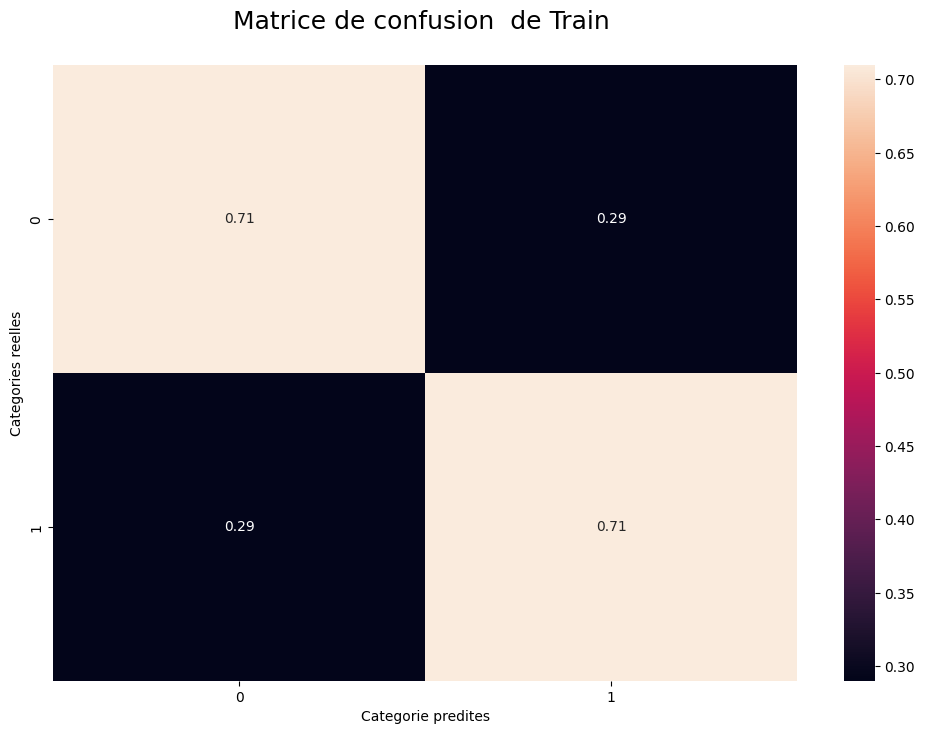

F2 score model 1 :  0.434358427003769


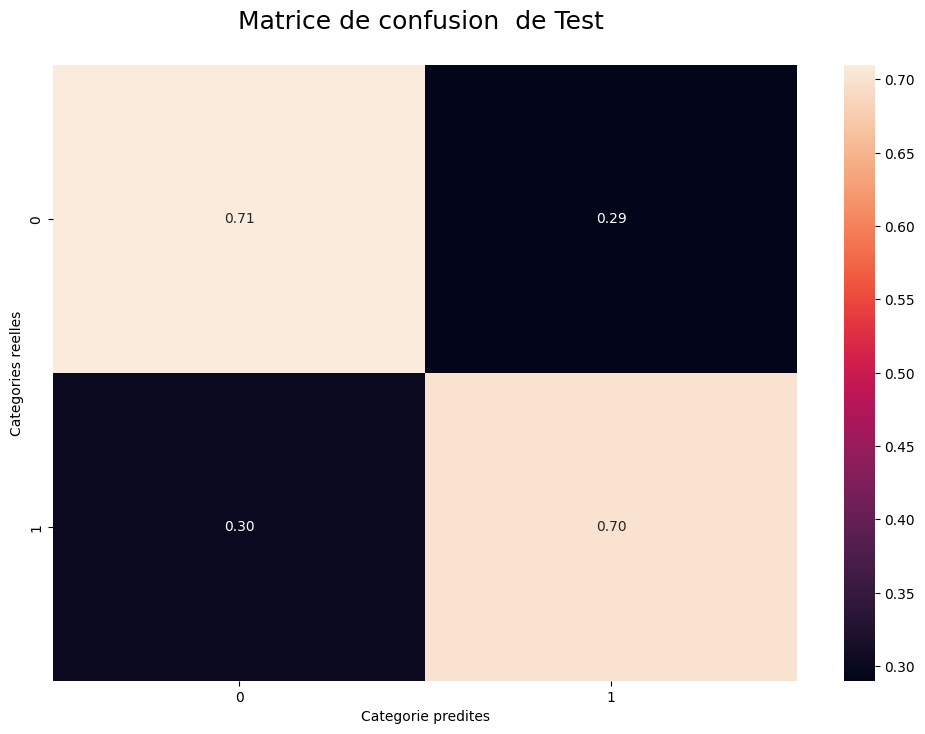

In [6]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", "Best LogReg")
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")

# GRID SEARCH RANDOM FOREST

In [10]:
estimator = RandomForestClassifier(n_estimators =  200, class_weight='balanced') #


# Parametres Random Forest
params = {
    'estimator__min_samples_split' : [100, 200, 500],
    'estimator__max_depth' : [15, 20, 50]
}

pipeline = Pipeline(
    [
        # ("feature_engineering", feature_engineering_transformer),
        ("imputer", imputer),
        ("scaler", scaler),
        ("over", over), # SMOTE does not accept missing values encoded as NaN natively.
        ("under", under), # SMOTE does not accept missing values encoded as NaN natively.
        ("estimator", estimator)
    ]
)

cv = StratifiedKFold(n_splits=5)

model = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv,
    scoring=custom_score,
    return_train_score=True
)

model.fit(X_train, y_train)

model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('over',
                                        SMOTE(random_state=42,
                                              sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(random_state=42,
                                                           sampling_strategy=0.5)),
                                       ('estimator',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=200))]),
             param_grid={'estimator__max_depth': [15, 20, 50],
                         'estimator__min_samples_split': [100, 200, 500]},
             return_train_score=True, scoring=make_scorer(custom_metric))

In [11]:
corr_matrix = train_df.corr()
most_correlated_to_target = corr_matrix.sort_values(by=['TARGET'], ascending=False).iloc[:101, 0].index

In [12]:
model = model.best_estimator_
model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('over', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('under',
                 RandomUnderSampler(random_state=42, sampling_strategy=0.5)),
                ('estimator',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_split=200,
                                        n_estimators=200))])

 TRAIN F2 score model :  0.5073271581166265


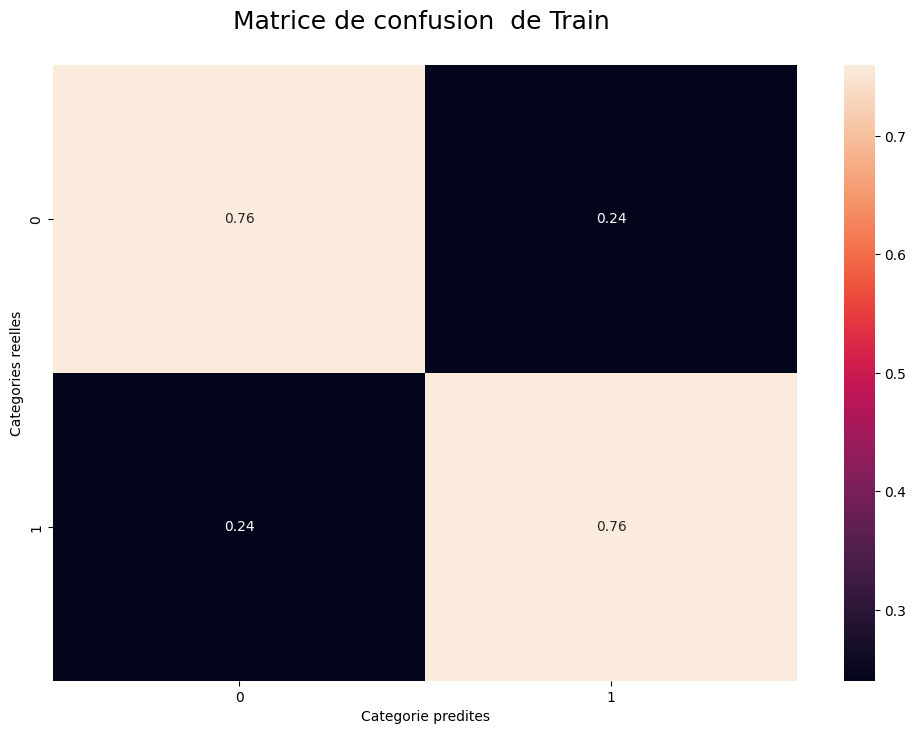

F2 score model 1 :  0.4189042582045023


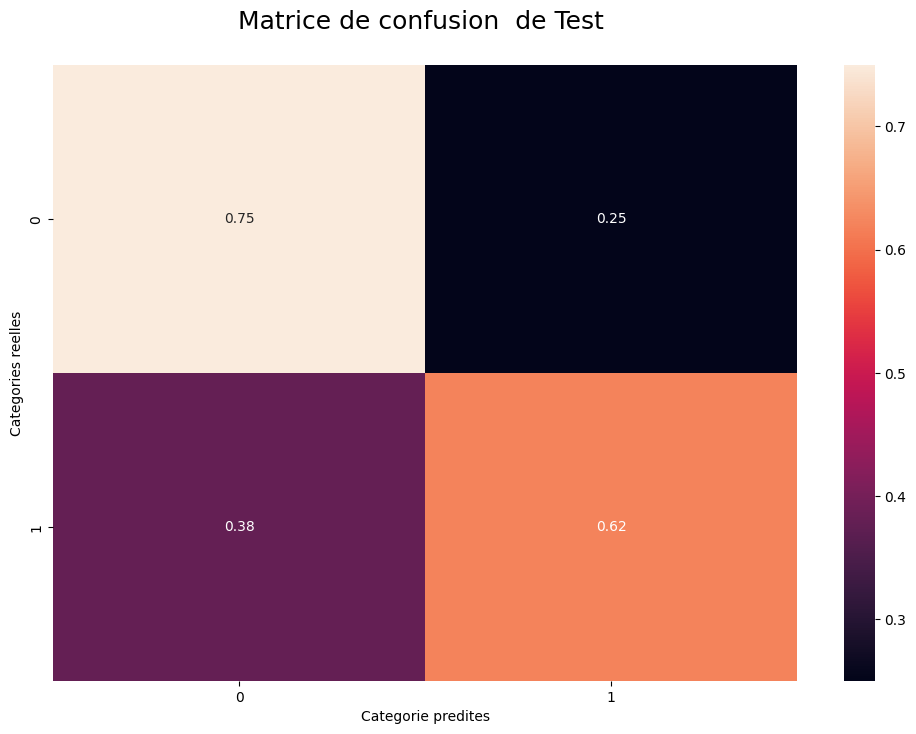

In [13]:
with mlflow.start_run():
    mlflow.log_param("Feature Engineering", "Not embedded in Pipeline")
    mlflow.log_param("imputer", str(imputer))
    mlflow.log_param("scaler", str(scaler))
    mlflow.log_param("estimator", str(model['estimator']))
    mlflow.log_param("over-sampler", str(over))
    mlflow.log_param("under-sampler", str(under))
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    # -------------------------- LOG RESULTS ------------------
    # Generation des resultats :
    # TRAIN RESULTS
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    train_auc_score = auc(fpr, tpr)
    train_F2_score = custom_metric(y_true=y_train, y_pred=y_train_pred)
    train_rappel = recall_score(y_true=y_train, y_pred=y_train_pred)
    print(" TRAIN F2 score model : ", train_F2_score)
    mlflow.log_metric("TRAIN F2 score", train_F2_score)
    mlflow.log_metric("TRAIN AUC", train_auc_score)
    mlflow.log_metric("TRAIN Recall", train_rappel)
    # Sauvegarde Confusion Test matrix
    train_img_mtrx = u810.matrice_confusion(y_true=y_train, y_pred=y_train_pred, complement_titre = " de Train",  path=DOSSIER_IMG, nomfichier="RegLog_Train_cm.png")
    mlflow.log_artifact(train_img_mtrx, "confusion_matrix")
    # TEST RESULTS
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    test_auc_score = auc(fpr, tpr)
    test_F2_score = custom_metric(y_true=y_test, y_pred=y_pred)
    test_rappel = recall_score(y_true=y_test, y_pred=y_pred)
    print("F2 score model 1 : ", test_F2_score)
    mlflow.log_metric("TEST F2 score", test_F2_score)
    mlflow.log_metric("TEST AUC", test_auc_score)
    mlflow.log_metric("TEST Recall", test_rappel)
    # Sauvegarde Confusion Test matrix
    test_img_mtrx = u810.matrice_confusion(y_true=y_test, y_pred=y_pred, complement_titre = " de Test", path=DOSSIER_IMG, nomfichier="RegLog_Test_cm.png")
    mlflow.log_artifact(test_img_mtrx, "confusion_matrix")